<a href="https://colab.research.google.com/github/TanyaSri-23/Image-Classification-and-Calories-Prediction/blob/main/CALORIE_PREDICTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING REQUIRED LIBRARIES

In [ ]:
import numpy as np
import cv2
import pandas as pd
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# IMPORTING DATASET

In [ ]:
train_dir = Path("/content/drive/MyDrive/train")
train_filepath = list(train_dir.glob(r"**/*.jpg"))

test_dir = Path("/content/drive/MyDrive/test")
test_filepath = list(test_dir.glob(r"**/*.jpg"))

val_dir = Path("/content/drive/MyDrive/validation")
val_filepath = list(val_dir.glob(r"**/*.jpg"))

# CREATING LABELS

In [ ]:
def process (filepath):

    
    i=0
    labels = [str(filepath[i]).split("/")[-2] 
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    data = pd.concat([filepath, labels], axis=1)

    data = df.sample(frac=1).reset_index(drop = True)
    
    return data

In [ ]:
train_df = process(train_filepath)
test_df = process(test_filepath)
val_df = process(val_filepath)
str(train_filepath[2750]).split("/")[-2]


'bell pepper'

In [ ]:
train_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/train/sweetcorn/Image_6...,sweetcorn
1,/content/drive/MyDrive/train/banana/Image_4.jpg,banana
2,/content/drive/MyDrive/train/jalepeno/Image_71...,jalepeno
3,/content/drive/MyDrive/train/spinach/Image_98.jpg,spinach
4,/content/drive/MyDrive/train/eggplant/Image_43...,eggplant


# DISPLAY DIFFERENT CLASSES

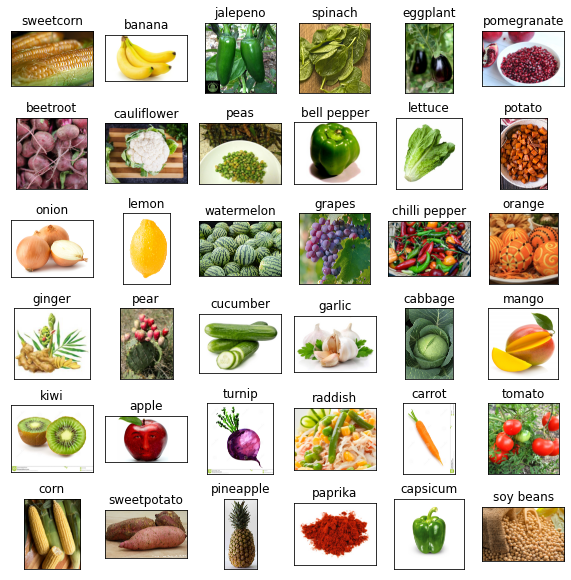

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
print(axes.flat)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

Text(0.5, 1.0, 'capsicum')

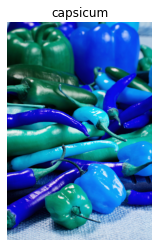

In [ ]:
img= cv2.imread(test_df["Filepath"][7])
plt.imshow(img)
plt.axis("off")
plt.title(str(test_df["Label"][7]))

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
type(train_generator)


keras.preprocessing.image.ImageDataGenerator

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


# TRANSFER LEARNING

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#pretrained_model.add(tf.keras.layers.Dense(12, activation = 'softmax'))

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
train_images

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1[9]

11/11 [==============================] - 113s 11s/step


'jalepeno'

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array


# PREDICTION FUNCTION

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
# pip install beautifulsoup4


In [ ]:
model.save('model.h5')

In [ ]:
res = output(r"/content/drive/MyDrive/train/spinach/Image_1.jpg")
res
s = f"Number of calories in {res}"

1/1 [==============================] - 0s 192ms/step


'spinach'

# CALORIES 

In [ ]:
try:
    from googlesearch import search
except ImportError:
    print("No module named 'google' found")
 
# to search
query = f"Number of calories in {res}"
 
for j in search(query, tld="co.in", num=1, stop=1, pause=3):
    print(j)
    print(f"Above Link Contains the Number of Calories for {res}")
    break

https://www.nutritionix.com/food/spinach
